#### Books Recommendation System Using Clustering | **``Colaborative Filtering``**

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

In [195]:
import pandas as pd 
import numpy as np
from vizpool.static import EDA
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import pickle
from pathlib import Path
import os 
from os import path
import gzip

In [271]:
books = pd.read_csv('data/BX-Books.csv', sep=";", error_bad_lines=False, encoding='latin-1')
print(books.shape)
books.head(2)

Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9



(271360, 8)


C:\Users\hasna\AppData\Local\Temp\ipykernel_17428\3663387549.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('data/BX-Books.csv', sep=";", error_bad_lines=False, encoding='latin-1')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [272]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [273]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher','Image-URL-L']]
books.rename(columns = {'Book-Title':'title',
             'Book-Author':'author',
             'Year-of-Publication':'year',
             'Publisher':'publisher',
             'Image-URL-L':'image_url'}, inplace=True)
books 

,ISBN,title,author,Year-Of-Publication,publisher,image_url
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...


In [274]:
users = pd.read_csv("./data/BX-Users.csv", sep=';', error_bad_lines=False, encoding='latin-1')
print(users.shape)
print(users.head(2))

(278858, 3)
   User-ID                   Location   Age
0        1         nyc, new york, usa   NaN
1        2  stockton, california, usa  18.0


In [275]:
ratings = pd.read_csv("./data/BX-Book-Ratings.csv", sep=';', error_bad_lines=False, encoding='latin-1')
ratings.rename(columns={'User-ID': 'user_id',
                        'Book-Rating':'rating'}, inplace = True)
print(ratings.shape)
print(ratings.head(2))

(1149780, 3)
   user_id        ISBN  rating
0   276725  034545104X       0
1   276726  0155061224       5


In [276]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 6)
(278858, 3)
(1149780, 3)


In [277]:
user_ratings = ratings['user_id'].value_counts().reset_index()
user_ratings.rename(columns ={'index':'User','user_id':'BooksRated'}, inplace = True)

In [278]:
user_ratings

,User,BooksRated
0,11676,13602
1,198711,7550
2,153662,6109
3,98391,5891
4,35859,5850
...,...,...
105278,116180,1
105279,116166,1
105280,116154,1
105281,116137,1


In [279]:
ratings_eda = EDA(user_ratings)

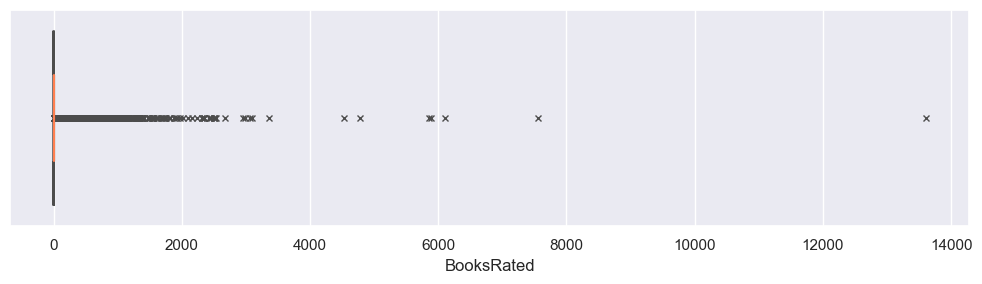

In [280]:
ratings_eda.boxplot("BooksRated", width=10, height=3);

It could be observed that some users have rated 1 or very few books, which would be considerd outliers

In [281]:
# Getting a list of users with the ratings more than 200
users_with_ratings = user_ratings[user_ratings['BooksRated'] > 200]['User'].tolist()
len(users_with_ratings)

899

In [282]:
ratings.head(2)

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5


In [283]:
# Getting the df with the users having the books rated more than 200
ratings = ratings[ratings['user_id'].isin(users_with_ratings)] 
ratings

,user_id,ISBN,rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0
...,...,...,...
1147612,275970,3829021860,0
1147613,275970,4770019572,0
1147614,275970,896086097,0
1147615,275970,9626340762,8


In [284]:
#get the books with got rated more than 200 times
rating_with_books = ratings.merge(books, on = 'ISBN', how = 'left')
rating_with_books

,user_id,ISBN,rating,title,author,Year-Of-Publication,publisher,image_url
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,http://images.amazon.com/images/P/0026217457.0...
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,http://images.amazon.com/images/P/003008685X.0...
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982,Henry Holt &amp; Co,http://images.amazon.com/images/P/0030615321.0...
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,http://images.amazon.com/images/P/0060002050.0...
...,...,...,...,...,...,...,...,...
526351,275970,3829021860,0,The Penis Book,Joseph Cohen,1999,Konemann,http://images.amazon.com/images/P/3829021860.0...
526352,275970,4770019572,0,Musashi,Eiji Yoshikawa,1995,Kodansha International (JPN),http://images.amazon.com/images/P/4770019572.0...
526353,275970,896086097,0,NaN,NaN,NaN,NaN,NaN
526354,275970,9626340762,8,Northanger Abbey (Classic Literature with Clas...,Jane Austen,1996,Naxos Audiobooks Ltd.,http://images.amazon.com/images/P/9626340762.0...


In [285]:
# To keep the data balanced now we will remove all the books with the very few ratings
books_rating_count = rating_with_books.groupby('title', as_index = False)['rating'].count()
books_rating_count.rename(columns={'rating':'no_of_ratings'}, inplace = True)
books_rating_count

,title,no_of_ratings
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1
...,...,...
160264,Ã?Â?ber die Pflicht zum Ungehorsam gegen den S...,3
160265,Ã?Â?lpiraten.,1
160266,Ã?Â?rger mit Produkt X. Roman.,1
160267,Ã?Â?stlich der Berge.,1


In [286]:
# Add the number of ratings for each book in rating df
final_rating = rating_with_books.merge(books_rating_count, on='title', how='left')
final_rating

,user_id,ISBN,rating,title,author,Year-Of-Publication,publisher,image_url,no_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82.0
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,http://images.amazon.com/images/P/0026217457.0...,7.0
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,http://images.amazon.com/images/P/003008685X.0...,1.0
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982,Henry Holt &amp; Co,http://images.amazon.com/images/P/0030615321.0...,1.0
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,http://images.amazon.com/images/P/0060002050.0...,13.0
...,...,...,...,...,...,...,...,...,...
526351,275970,3829021860,0,The Penis Book,Joseph Cohen,1999,Konemann,http://images.amazon.com/images/P/3829021860.0...,1.0
526352,275970,4770019572,0,Musashi,Eiji Yoshikawa,1995,Kodansha International (JPN),http://images.amazon.com/images/P/4770019572.0...,1.0
526353,275970,896086097,0,NaN,NaN,NaN,NaN,NaN,NaN
526354,275970,9626340762,8,Northanger Abbey (Classic Literature with Clas...,Jane Austen,1996,Naxos Audiobooks Ltd.,http://images.amazon.com/images/P/9626340762.0...,2.0


In [287]:
final_rating = final_rating[final_rating['no_of_ratings'] >= 50]
final_rating

,user_id,ISBN,rating,title,author,Year-Of-Publication,publisher,image_url,no_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82.0
13,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,133.0
15,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,2002,Perennial,http://images.amazon.com/images/P/0060934417.0...,108.0
18,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,http://images.amazon.com/images/P/0061009059.0...,108.0
24,277427,006440188X,0,The Secret Garden,Frances Hodgson Burnett,1998,HarperTrophy,http://images.amazon.com/images/P/006440188X.0...,79.0
...,...,...,...,...,...,...,...,...,...
526179,275970,1400031354,0,Tears of the Giraffe (No.1 Ladies Detective Ag...,Alexander McCall Smith,2002,Anchor,http://images.amazon.com/images/P/1400031354.0...,84.0
526180,275970,1400031362,0,Morality for Beautiful Girls (No.1 Ladies Dete...,Alexander McCall Smith,2002,Anchor,http://images.amazon.com/images/P/1400031362.0...,60.0
526256,275970,1573229725,0,Fingersmith,Sarah Waters,2002,Riverhead Books,http://images.amazon.com/images/P/1573229725.0...,59.0
526295,275970,1586210661,9,Me Talk Pretty One Day,David Sedaris,2001,Time Warner Audio Major,http://images.amazon.com/images/P/1586210661.0...,146.0


In [288]:
# Checking for duplicates
final_rating[final_rating.duplicated(subset=['user_id', 'title'])].shape

(2003, 9)

In [289]:
# Droping Duplicates
final_rating = final_rating.drop_duplicates(subset=['user_id', 'title'])
final_rating.shape

(59850, 9)

In [290]:
books_pivot = final_rating.pivot_table(columns='user_id', index= 'title', values = 'rating')
books_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11676,11993,12538,12824,12982,13082,13273,13552,13850,14422,14521,15408,15418,15957,16106,16634,16795,16916,16966,17950,18067,18401,19085,19664,20115,20201,21014,21252,21576,21659,22625,23288,23768,23872,...,258152,258185,258534,258690,258938,259260,259380,259629,260183,260897,261037,261105,261829,262399,262998,263163,263460,263877,264031,264082,264317,264321,264637,265115,265313,265595,265889,266056,266226,266753,266865,266866,267635,268030,268032,268110,268330,268622,268932,269566,269719,269728,269890,270713,270820,271195,271284,271448,271705,273979,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84 Charing Cross Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0

In [291]:
books_pivot.fillna(0, inplace=True)
books_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11676,11993,12538,12824,12982,13082,13273,13552,13850,14422,14521,15408,15418,15957,16106,16634,16795,16916,16966,17950,18067,18401,19085,19664,20115,20201,21014,21252,21576,21659,22625,23288,23768,23872,...,258152,258185,258534,258690,258938,259260,259380,259629,260183,260897,261037,261105,261829,262399,262998,263163,263460,263877,264031,264082,264317,264321,264637,265115,265313,265595,265889,266056,266226,266753,266865,266866,267635,268030,268032,268110,268330,268622,268932,269566,269719,269728,269890,270713,270820,271195,271284,271448,271705,273979,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [292]:
book_spare = csr_matrix(books_pivot)
book_spare

<742x888 sparse matrix of type '<class 'numpy.float64'>'
	with 14961 stored elements in Compressed Sparse Row format>

In [293]:
# Model building
model = NearestNeighbors(algorithm='brute')
model.fit(book_spare)

NearestNeighbors(algorithm='brute')

In [294]:
distance , suggestions = model.kneighbors(books_pivot.iloc[237, :].values.reshape(1, -1), n_neighbors=11)

In [295]:
distance, suggestions

(array([[ 0.        , 67.75691847, 68.05145112, 72.277244  , 75.81556568,
         76.30203143, 76.32823855, 76.62245102, 76.64202503, 76.75285011,
         76.81796665]]),
 array([[237, 238, 240, 241, 184, 536, 291, 686, 675, 689, 691]],
       dtype=int64))

In [296]:
for i in range(len(suggestions)):
    print(books_pivot.index[suggestions[i]])

Index(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Sorcerer's Stone (Book 1)', 'Exclusive',
       'The Cradle Will Fall', 'Jacob Have I Loved',
       'Tom Clancy's Op-Center (Tom Clancy's Op Center (Paperback))',
       'The Witness', 'Toxin', 'Truly, Madly Manhattan'],
      dtype='object', name='title')


In [298]:
book_pivot.index[22]

'A Prayer for Owen Meany'

In [299]:
books_name = book_pivot.index 

In [300]:
os.makedirs('artifacts/', exist_ok=True)
with gzip.open(Path(os.path.join("artifacts", "model.pkl.gz")).resolve().absolute(), 'wb') as f:
    pickle.dump(model, f)
    
with gzip.open(Path(os.path.join("artifacts", "books_name.pkl.gz")).resolve().absolute(), 'wb') as f: 
    pickle.dump(books_name, f)
    
with gzip.open(Path(os.path.join("artifacts", "final_ratings.pkl.gz")).resolve().absolute(), 'wb') as f: 
    pickle.dump(final_rating, f)
    
with gzip.open(Path(os.path.join("artifacts", "books_pivot.pkl.gz")).resolve().absolute(), 'wb') as f: 
    pickle.dump(books_pivot, f)

In [302]:
def unzip_artifacts(dir : path='artifacts/', ext: tuple=(".gz"))-> None:
    for file in os.listdir(dir):
        if file.endswith(ext):
            file = Path(os.path.join(dir,file)).resolve().absolute()
            with gzip.open(file, 'rb') as f :
                loaded_artifact = pickle.load(f)
            with open(os.path.join(str(file.parent), str(file.stem)), 'wb') as f: 
                pickle.dump(loaded_artifact, f)
            os.remove(file)

In [303]:
unzip_artifacts()

In [304]:
def recommend_books(book_name : str) -> list[str]:
    book_id = np.where(book_pivot.index == book_name)[0][0]
    distance , suggestions = model.kneighbors(books_pivot.iloc[book_id, :].values.reshape(1, -1),
                                                n_neighbors=6)
    print(suggestions)
    print(len(suggestions))
    books = book_pivot.index[suggestions[0]]
    for j in books:
        print(j)
    return books

In [305]:
books = recommend_books("Family Album")
books 

[[196 372 184 536 485 200]]
1
Family Album
No Safe Place
Exclusive
The Cradle Will Fall
Table For Two
Fatal Cure


Index(['Family Album', 'No Safe Place', 'Exclusive', 'The Cradle Will Fall',
       'Table For Two', 'Fatal Cure'],
      dtype='object', name='title')

In [306]:
books

Index(['Family Album', 'No Safe Place', 'Exclusive', 'The Cradle Will Fall',
       'Table For Two', 'Fatal Cure'],
      dtype='object', name='title')

In [307]:
final_rating

,user_id,ISBN,rating,title,author,Year-Of-Publication,publisher,image_url,no_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82.0
13,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,133.0
15,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,2002,Perennial,http://images.amazon.com/images/P/0060934417.0...,108.0
18,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,http://images.amazon.com/images/P/0061009059.0...,108.0
24,277427,006440188X,0,The Secret Garden,Frances Hodgson Burnett,1998,HarperTrophy,http://images.amazon.com/images/P/006440188X.0...,79.0
...,...,...,...,...,...,...,...,...,...
526179,275970,1400031354,0,Tears of the Giraffe (No.1 Ladies Detective Ag...,Alexander McCall Smith,2002,Anchor,http://images.amazon.com/images/P/1400031354.0...,84.0
526180,275970,1400031362,0,Morality for Beautiful Girls (No.1 Ladies Dete...,Alexander McCall Smith,2002,Anchor,http://images.amazon.com/images/P/1400031362.0...,60.0
526256,275970,1573229725,0,Fingersmith,Sarah Waters,2002,Riverhead Books,http://images.amazon.com/images/P/1573229725.0...,59.0
526295,275970,1586210661,9,Me Talk Pretty One Day,David Sedaris,2001,Time Warner Audio Major,http://images.amazon.com/images/P/1586210661.0...,146.0


In [308]:
urls = final_rating[final_rating['title'].isin(books)][['title', 'image_url']].\
        drop_duplicates(subset='title', keep='first').to_dict('records')
urls

[{'title': 'No Safe Place',
  'image_url': 'http://images.amazon.com/images/P/0345404777.01.LZZZZZZZ.jpg'},
 {'title': 'Fatal Cure',
  'image_url': 'http://images.amazon.com/images/P/0425145638.01.LZZZZZZZ.jpg'},
 {'title': 'Family Album',
  'image_url': 'http://images.amazon.com/images/P/0440124344.01.LZZZZZZZ.jpg'},
 {'title': 'Table For Two',
  'image_url': 'http://images.amazon.com/images/P/0373218400.01.LZZZZZZZ.jpg'},
 {'title': 'Exclusive',
  'image_url': 'http://images.amazon.com/images/P/0446604232.01.LZZZZZZZ.jpg'},
 {'title': 'The Cradle Will Fall',
  'image_url': 'http://images.amazon.com/images/P/0440115450.01.LZZZZZZZ.jpg'}]